## Step 0: Loading Necessary Libraries
Before we begin our analysis and modeling, we need to import all the necessary libraries.  vertaal naar het nederlands

In [1]:
# Import the necessary libraries for data processing and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for model selection and evaluation
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, recall_score, balanced_accuracy_score, fbeta_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Import the models
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

# Import libraries for interactive dashboards
from dash import html, dcc, Input, Output, Dash
import plotly.express as px
import scipy.stats as ss


## Step 1: Loading the Dataset
First, we need to load the dataset into our environment. 

In [2]:
# Load the dataset
file_path = 'C:\\Users\\basti\\OneDrive\\Sollicitaties\\Techonomy\\bank-additional\\bank-additional-full.csv'  
df = pd.read_csv(file_path, delimiter=';')

# Display the first few rows of the dataset
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Step 2: Exploring the Dataset
After loading the dataset, the next step is to explore it to understand its structure, check for missing values, and analyze the distribution of the target variable.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

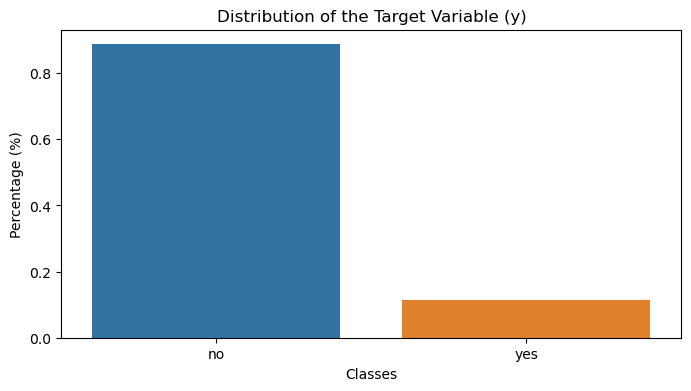

Missing Values:
No missing values

Target Distribution:
no     0.887346
yes    0.112654


In [3]:
# Checking the general information of the dataset
info = df.info()

# Checking for missing values in the dataset and filtering only columns with missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

# Analyzing and visualizing the distribution of the target variable
target_distribution = df['y'].value_counts(normalize=True)
target_distribution_text = target_distribution.to_string() 

# Plotting the distribution
plt.figure(figsize=(8, 4))
sns.barplot(x=target_distribution.index, y=target_distribution.values)
plt.title('Distribution of the Target Variable (y)')
plt.ylabel('Percentage (%)')
plt.xlabel('Classes')
plt.show()
plt.close()

# Preparing the output
missing_values_output = "No missing values" if missing_values.empty else missing_values
info_output = f"Missing Values:\n{missing_values_output}\n\nTarget Distribution:\n{target_distribution_text}"

print(info_output)

## Step 3: Training and Evaluating the Classification Model
In this step, I will train a LightGBM classifier using nested cross-validation and grid search for hyperparameter tuning. To address the class imbalance in the dataset, I will incorporate SMOTE (Synthetic Minority Over-sampling Technique) in the pipeline. Note the hyperparameter set is narrow and only a few folds are used to reduce computational expensiveness as this is only for assignment purposes. 

### Definieer de basis en de functies

In [4]:
# Separate the target variable
X = df.drop(columns=['y'])
y = df['y'].map({'no': 0, 'yes': 1})

In [5]:
# Functie voor de nested cross validation
def perform_nested_cv(model, X, y, param_grid, outer_splits=2, inner_splits=2):
    model_name = model.__class__.__name__
    print(f"Evaluating Model: {model_name}")

    # Define outer and inner cross-validation
    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=5)
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=5)

    # Initialize lists to store metrics
    train_f2_scores = []
    test_balanced_accuracies = []
    test_recalls = []
    test_f2_scores = []
    confusion_matrices = []
    best_hyperparameters = []

    for train_index, test_index in outer_cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Identify categorical features
        categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
        numerical_features = X_train.select_dtypes(exclude=['object', 'category']).columns.tolist()

        # Create a ColumnTransformer for one-hot encoding and standard scaling
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_features),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
            remainder='drop'
        )
        
        # Create a pipeline that first one-hot encodes, then applies SMOTE, and finally fits the model
        pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=5)),
            ('classifier', model)
        ])

        # Perform grid search for hyperparameters
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            scoring='f1',
            cv=inner_cv,
            n_jobs=-1
        )

        # Fit the grid search on the training data
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_

        # Store the best hyperparameters
        best_hyperparams = grid_search.best_params_
        best_hyperparameters.append(best_hyperparams)


        # Train and Test predictions
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        # Compute metrics
        train_f2_score = fbeta_score(y_train, y_train_pred, beta=2)
        test_balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
        test_recall = recall_score(y_test, y_test_pred)
        test_f2_score = fbeta_score(y_test, y_test_pred, beta=2)

        # Append metrics to their respective lists
        train_f2_scores.append(train_f2_score)
        test_balanced_accuracies.append(test_balanced_accuracy)
        test_recalls.append(test_recall)
        test_f2_scores.append(test_f2_score)

        # Compute and store the confusion matrix for this fold
        cm = confusion_matrix(y_test, y_test_pred)
        confusion_matrices.append(cm)

    # Calculate average and standard deviation of the metrics
    avg_train_f2_score = np.mean(train_f2_scores)
    std_train_f2_score = np.std(train_f2_scores)
    avg_test_balanced_accuracy = np.mean(test_balanced_accuracies)
    std_test_balanced_accuracy = np.std(test_balanced_accuracies)
    avg_test_recall = np.mean(test_recalls)
    std_test_recall = np.std(test_recalls)
    avg_test_f2_score = np.mean(test_f2_scores)
    std_test_f2_score = np.std(test_f2_scores)

    # Calculate the mean confusion matrix across all folds
    mean_confusion_matrix = np.mean(confusion_matrices, axis=0)

    return {
        "avg_train_f2_score": avg_train_f2_score,
        "std_train_f2_score": std_train_f2_score,
        "avg_test_balanced_accuracy": avg_test_balanced_accuracy,
        "std_test_balanced_accuracy": std_test_balanced_accuracy,
        "avg_test_recall": avg_test_recall,
        "std_test_recall": std_test_recall,
        "avg_test_f2_score": avg_test_f2_score,
        "std_test_f2_score": std_test_f2_score,
        "mean_confusion_matrix": mean_confusion_matrix,
        "fold_results": {
            "train_f2_scores": train_f2_scores,
            "test_balanced_accuracies": test_balanced_accuracies,
            "test_recalls": test_recalls,
            "test_f2_scores": test_f2_scores,
            "best_hyperparameters": best_hyperparameters  # Storing best hyperparameters here
        }
    }


In [6]:
#Functie om de resultaten te printen
def print_results(results):
    fold_results = results["fold_results"]
    for fold, fold_result in enumerate(fold_results["train_f2_scores"]):
        print(f"Fold {fold + 1}:")
        print(f"Train F2 Score: {fold_result:.3f}")
        print(f"Test Balanced Accuracy: {fold_results['test_balanced_accuracies'][fold]:.3f}")
        print(f"Test Recall: {fold_results['test_recalls'][fold]:.3f}")
        print(f"Test F2 Score: {fold_results['test_f2_scores'][fold]:.3f}")
        print(f"Best Hyperparameters: {fold_results['best_hyperparameters'][fold]}")
        print("----------")
    
    print("Total Results:")
    print(f"Average Train F2 Score: {results['avg_train_f2_score']:.3f} (±{results['std_train_f2_score']:.3f})")
    print(f"Average Test Balanced Accuracy: {results['avg_test_balanced_accuracy']:.3f} (±{results['std_test_balanced_accuracy']:.3f})")
    print(f"Average Test Recall: {results['avg_test_recall']:.3f} (±{results['std_test_recall']:.3f})")
    print(f"Average Test F2 Score: {results['avg_test_f2_score']:.3f} (±{results['std_test_f2_score']:.3f})")

    print("Mean Confusion Matrix:")
    print(results["mean_confusion_matrix"])

### Train the baseline model and the advanced model

In [7]:
# Create a Logistic Regression classifier with increased max_iter
lr_model = LogisticRegression(random_state=5, max_iter=1000)

# Evaluate the Logistic Regression model without specifying a hyperparameter grid (baseline)
results_lr = perform_nested_cv(lr_model, X, y, {})

# Print all results for Logistic Regression
print_results(results_lr)

Evaluating Model: LogisticRegression


Fold 1:
Train F2 Score: 0.734
Test Balanced Accuracy: 0.869
Test Recall: 0.871
Test F2 Score: 0.737
Best Hyperparameters: {}
----------
Fold 2:
Train F2 Score: 0.746
Test Balanced Accuracy: 0.868
Test Recall: 0.876
Test F2 Score: 0.732
Best Hyperparameters: {}
----------
Total Results:
Average Train F2 Score: 0.740 (±0.006)
Average Test Balanced Accuracy: 0.869 (±0.001)
Average Test Recall: 0.873 (±0.003)
Average Test F2 Score: 0.734 (±0.002)
Mean Confusion Matrix:
[[15788.  2486.]
 [  294.  2026.]]


In [8]:
# Create a LightGBM classifier 
lgb_model = LGBMClassifier(random_state=5, verbose=-1)

# Define the parameter grid for LightGBM
lgb_param_grid = {
    'classifier__n_estimators': [300, 350, 400],  # Narrowing around 300
    'classifier__learning_rate': [0.005, 0.01, 0.02],  # Increasing resolution around 0.01
    'classifier__max_depth': [10, 12, 15]  # Expanding and increasing resolution around 10-15
}

# Evaluate the LightGBM model
results_lgb = perform_nested_cv(lgb_model, X, y, lgb_param_grid)

# Print all results
print_results(results_lgb)

Evaluating Model: LGBMClassifier
Fold 1:
Train F2 Score: 0.772
Test Balanced Accuracy: 0.860
Test Recall: 0.810
Test F2 Score: 0.734
Best Hyperparameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 10, 'classifier__n_estimators': 350}
----------
Fold 2:
Train F2 Score: 0.774
Test Balanced Accuracy: 0.869
Test Recall: 0.834
Test F2 Score: 0.747
Best Hyperparameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 15, 'classifier__n_estimators': 350}
----------
Total Results:
Average Train F2 Score: 0.773 (±0.001)
Average Test Balanced Accuracy: 0.865 (±0.005)
Average Test Recall: 0.822 (±0.012)
Average Test F2 Score: 0.741 (±0.006)
Mean Confusion Matrix:
[[16585.5  1688.5]
 [  412.5  1907.5]]


## Step 4 Feature Importance

In [9]:
# Split the data into train and test sets using a stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=5, stratify=y)

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object', 'category']).columns.tolist()

# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='drop')

# Function to create and fit a model pipeline
def create_and_fit_pipeline(model, X_train, y_train):
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=5)),
        ('classifier', model)])
    pipeline.fit(X_train, y_train)
    return pipeline

# Function to compute and sort permutation feature importance
def compute_sorted_importance(pipeline, X_test, y_test):
    importances = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=5)
    sorted_features = pd.Series(importances['importances_mean'], index=X.columns).sort_values(ascending=False)
    return sorted_features


In [10]:
# Create and fit the advanced and baseline models
lgb_model = LGBMClassifier(random_state=5, n_estimators=300, learning_rate=0.01, max_depth=10, verbose =-1)
lgb_pipeline = create_and_fit_pipeline(lgb_model, X_train, y_train)

lr_model = LogisticRegression(random_state=5, max_iter = 1000)
lr_pipeline = create_and_fit_pipeline(lr_model, X_train, y_train)

# Compute and sort feature importance for both models
lgb_sorted_features = compute_sorted_importance(lgb_pipeline, X_test, y_test)
lr_sorted_features = compute_sorted_importance(lr_pipeline, X_test, y_test)

# Print sorted feature importances
print("Advanced Model Sorted Feature Importances:\n", lgb_sorted_features)
print("\nBaseline Model Sorted Feature Importances:\n", lr_sorted_features)

Advanced Model Sorted Feature Importances:
 duration          0.087902
euribor3m         0.048386
emp.var.rate      0.029781
nr.employed       0.016347
cons.price.idx    0.003642
day_of_week       0.002687
poutcome          0.001691
campaign          0.001408
month             0.001084
previous          0.000429
cons.conf.idx     0.000267
marital           0.000218
loan              0.000210
pdays             0.000202
age              -0.000113
housing          -0.000308
default          -0.000356
education        -0.000736
job              -0.001529
contact          -0.002881
dtype: float64

Baseline Model Sorted Feature Importances:
 emp.var.rate      0.219883
cons.price.idx    0.092029
euribor3m         0.079178
duration          0.065558
nr.employed       0.015165
month             0.014866
poutcome          0.003617
pdays             0.001109
day_of_week       0.000210
loan              0.000194
housing           0.000162
cons.conf.idx     0.000129
previous          0.000057
age  

## Step 5 Make the Dashboard

### Miscellaneous for the dashboard

In [11]:
# Define more informative columns
informative_columns = {
    "age": "Age",
    "job": "Job Type",
    "marital": "Marital Status",
    "education": "Education Level",
    "default": "Credit Default",
    "housing": "Housing Loan",
    "loan": "Personal Loan",
    "contact": "Contact Type",
    "month": "Last Contact Month",
    "day_of_week": "Last Contact Day Of Week",
    "duration": "Last Contact Duration",
    "campaign": "Contacts During Campaign",
    "pdays": "Days Since Last Contact",
    "previous": "Contacts Before Campaign",
    "poutcome": "Previous Campaign Outcome",
    "emp.var.rate": "Employment Variation Rate",
    "cons.price.idx": "Consumer Price Index",
    "cons.conf.idx": "Consumer Confidence Index",
    "euribor3m": "Euribor 3 Month Rate",
    "nr.employed": "Number Of Employees",
    "y": "Subscribed Term Deposit"
}

# Identify categorical and numerical features
categorical_features = [col for col in df.select_dtypes(include=['object', 'category']).columns.tolist() if col != 'y']
numerical_features = df.select_dtypes(include=['number']).columns.tolist()

#Define a function to calculate correlation for categorical features
def cramer_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

### Dashboard

In [15]:
# Initialize the Dash application
app = Dash(__name__)

# Define the layout of the dashboard
app.layout = html.Div([
    # Main title of the dashboard
    html.Div([
        html.H1(children='Predicting if a Customer Subscribes to a Term Deposit', style={'textAlign': 'center'}),
    ], style={'marginBottom': '20px'}),

    # Subheading for data exploration with textual explanation
    html.Div([
        html.H3("Data Exploration", style={'textAlign': 'center'}),
        html.P("This section displays a Correlation Matrix showcasing the association of features with the target variable and a feature selection tool to plot individual features against the target variable.", style={'padding': '10px', 'textAlign': 'center'}),
    ], style={'backgroundColor': '#EFEFEF', 'marginBottom': '20px'}),

    # Dropdown menu for selecting a feature for the feature - target graph
    html.Div([
        html.Div(style={'width': '50%'}), 
        html.Div([
            html.H3("Select a Feature for the Graph:"),
            dcc.Dropdown(
                options=[{'label': informative_columns.get(col, col), 'value': col}
                         for col in categorical_features + numerical_features],
                id='dropdown-feature',
                value=categorical_features[1]
            ),
        ], style={'width': '50%', 'display': 'inline-block', 'verticalAlign': 'top'}),
    ], style={'display': 'flex', 'marginBottom': '20px'}),

    # The correlation graph and feature - target graphs
    html.Div([
        html.Div([
            dcc.Graph(id='graph-feature-correlation', style={'height': '100%'})  
        ], style={'width': '50%', 'display': 'inline-block', 'verticalAlign': 'top'}),
        html.Div([
            dcc.Graph(id='graph-feature', style={'height': '100%'}),  
        ], style={'width': '50%', 'display': 'inline-block', 'verticalAlign': 'top'}),
    ], style={'display': 'flex'}),

    # Subheading for model performance with textual explanation
    html.Div([
        html.H3("Model Performance", style={'textAlign': 'center'}),
        html.P("This section of the dashboard showcases the predictive performance and feature importance of the baseline model (Logistic Regession) and the advanced model (LightGBM). Appropriate performance metrics are showcased alligning with the objective of maximizing the amount of subscriptions on term deposits.", style={'padding': '10px', 'textAlign': 'center'}),
    ], style={'backgroundColor': '#EFEFEF', 'marginBottom': '20px'}),

    # Dropdown menu for selecting a model
    html.Div([
        html.Div([
            html.H3("Select a Model:"),
            dcc.Dropdown(
                options=[
                    {'label': 'Baseline Model', 'value': 'baseline'},
                    {'label': 'LGB Model', 'value': 'lgb'}
                ],
                id='model-dropdown',
                value='baseline'
            ),
        ], style={'padding': '10px'}),
    ], style={'marginBottom': '20px'}),

    # Display of performance metrics
    html.Div([
        html.Div([
            html.P(id='balanced-accuracy'),
        ], style={'width': '33%', 'display': 'inline-block', 'border': '1px solid #ccc', 'padding': '10px', 'margin': '5px', 'backgroundColor': '#D6E9C6'}),
        html.Div([
            html.P(id='recall'),
        ], style={'width': '33%', 'display': 'inline-block', 'border': '1px solid #ccc', 'padding': '10px', 'margin': '5px', 'backgroundColor': '#D6E9C6'}),
        html.Div([
            html.P(id='f2-score'),
        ], style={'width': '33%', 'display': 'inline-block', 'border': '1px solid #ccc', 'padding': '10px', 'margin': '5px', 'backgroundColor': '#D6E9C6'}),
    ], style={'display': 'flex', 'marginBottom': '20px'}),

    # Display of the confusion matrix and feature importance graph
    html.Div([
        html.Div([
            dcc.Graph(id='graph-confusion-matrix'),
        ], style={'width': '50%', 'display': 'inline-block', 'verticalAlign': 'top'}),
        html.Div([
            dcc.Graph(id='graph-feature-importance'),
        ], style={'width': '50%', 'display': 'inline-block', 'verticalAlign': 'top'}),
    ], style={'display': 'flex'}),

    # Interval component for updating the correlation graph once (to trigger the correlation graph)
    dcc.Interval(
        id='interval-component',
        interval=86400000, 
        n_intervals=0
    )
])

# Callback for updating the first graph based on the selected feature
@app.callback(
    Output('graph-feature', 'figure'),
    Input('dropdown-feature', 'value')
)
def update_feature_graph(selected_feature):
    # Check if the selected feature is categorical
    if selected_feature in categorical_features:
        # Sort the categories alphabetically
        sorted_categories = df[selected_feature].sort_values().unique()
        
        # Create a histogram for categorical features showing the percentage
        fig = px.histogram(df, x=selected_feature, color='y', 
                           histnorm='percent', barmode='group',
                           category_orders={selected_feature: sorted_categories},
                           labels={
                               selected_feature: informative_columns.get(selected_feature, selected_feature),
                               'y': informative_columns.get('y', 'y')
                           })

        fig.update_layout(
            yaxis_title='Percentage of Total (%)',
            title=f'Distribution of {informative_columns.get(selected_feature, selected_feature)} by Target Variable',
            xaxis_title=informative_columns.get(selected_feature, selected_feature)
        )
        return fig
    else:
        # Box plot for numerical features
        return px.box(df, x='y', y=selected_feature, labels={
            'y': informative_columns.get('y', 'y'),
            selected_feature: informative_columns.get(selected_feature, selected_feature)
        })

# Callback for updating the correlation graph
@app.callback(
    Output('graph-feature-correlation', 'figure'),
    Input('interval-component', 'n_intervals')
)
def update_correlation_graph(_):
    # Create a copy of the DataFrame
    temp_df = df.copy()

    # Convert the target variable 'y' to binary 
    temp_df['y'] = temp_df['y'].map({'yes': 1, 'no': 0})

    # Calculate correlations for numeric features
    numeric_features = temp_df[numerical_features]
    numeric_correlations = numeric_features.corrwith(temp_df['y']).sort_values(ascending=True)

    # Calculate associations for categorical features using cramer_v
    categorical_associations = {feature: cramer_v(temp_df[feature], temp_df['y']) 
                                for feature in categorical_features}

    # Combine and sort results
    combined_results = numeric_correlations.append(pd.Series(categorical_associations)).sort_values(ascending=True)

    # Rename the indices to use informative column names for the index
    combined_results.index = [informative_columns.get(idx, idx) for idx in combined_results.index]

    # Create a bar chart for correlations and associations
    correlation_fig = px.bar(
        x=combined_results.values,
        y=combined_results.index,
        orientation='h',
        labels={'x': 'Association with Target', 'y': 'Feature'},
        title='Association of Features with Target Variable',
        color=combined_results.apply(lambda x: 'Negative' if x < 0 else 'Positive'),
        color_discrete_map={'Negative': 'red', 'Positive': 'blue'}
    )

    # Hide the legend and set figure height
    correlation_fig.update_layout(showlegend=False)
    correlation_fig.update_layout(height=600)
    return correlation_fig

@app.callback(
    Output('graph-feature-importance', 'figure'),
    Input('model-dropdown', 'value')
)
def update_feature_importance_graph(selected_model):
    # Determine which model's feature importances to use
    if selected_model == 'baseline':
        feature_importances = lr_sorted_features 
    else:
        feature_importances = lgb_sorted_features 

    # Create a bar chart for feature importance
    informative_sorted_features = feature_importances.rename(index=informative_columns)
    fig = px.bar(
        informative_sorted_features, 
        orientation='h', 
        labels={'index': 'Feature', 'value': 'Importance'}
    )
    fig.update_layout(
        yaxis={'categoryorder': 'total ascending'},
        title_text='Feature Importance',
        showlegend=False
    )
    return fig

# Callback for updating the confusion matrix graph based on the selected model
@app.callback(
    Output('graph-confusion-matrix', 'figure'),
    [Input('model-dropdown', 'value')]
)
def update_confusion_matrix_graph(selected_model):
    # Update the confusion matrix based on the selected model
    if selected_model == 'baseline':
        # Convert the average confusion matrix to a DataFrame for the Baseline Model
        conf_matrix_df = pd.DataFrame(
            results_lr["mean_confusion_matrix"], 
            index=["Actual Negative", "Actual Positive"], 
            columns=["Predicted Negative", "Predicted Positive"]
        )
        title_text = 'Confusion Matrix for Baseline Model'
    else:
        # Convert the average confusion matrix to a DataFrame for the LGB Model
        conf_matrix_df = pd.DataFrame(
            results_lgb["mean_confusion_matrix"], 
            index=["Actual Negative", "Actual Positive"], 
            columns=["Predicted Negative", "Predicted Positive"]
        )
        title_text = 'Confusion Matrix for LGB Model'

    # Create a heatmap of the confusion matrix
    fig_confusion = px.imshow(
        conf_matrix_df,
        labels=dict(x="Predicted Class", y="Actual Class", color="Count"),
        x=['Predicted Negative', 'Predicted Positive'],
        y=['Actual Negative', 'Actual Positive'],
        text_auto='.2s',
        color_continuous_scale=px.colors.sequential.Viridis
    )

    # Update the layout for the confusion matrix
    fig_confusion.update_layout(
        title_text=title_text,
        xaxis_title='Predicted Class',
        yaxis_title='Actual Class',
        coloraxis_showscale=False
    )

    fig_confusion.update_xaxes(side="bottom")

    return fig_confusion

# Callback for updating performance metrics based on the selected model
@app.callback(
    [Output('balanced-accuracy', 'children'),
     Output('recall', 'children'),
     Output('f2-score', 'children')],
    [Input('model-dropdown', 'value')]
)
def update_performance_metrics(selected_model):
    if selected_model == 'baseline':
        results = results_lr
    else:
        results = results_lgb

    # Update the metrics
    balanced_accuracy = f"Balanced Accuracy: {results['avg_test_balanced_accuracy']:.2f} (±{results['std_test_balanced_accuracy']:.2f})"
    recall = f"Recall: {results['avg_test_recall']:.2f} (±{results['std_test_recall']:.2f})"
    f2_score = f"F2 Score: {results['avg_test_f2_score']:.2f} (±{results['std_test_f2_score']:.2f})"

    return balanced_accuracy, recall, f2_score

# Start the dashboard
if __name__ == '__main__':
    app.run_server(debug=True)


C:\Users\basti\AppData\Local\Temp\ipykernel_5196\2131176437.py:147: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

